In [1]:
import pybedtools as pbt
import pysam
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as ss
import csv
import matplotlib.pyplot as plt
import hgvs.parser
import hgvs.dataproviders.uta
import hgvs.assemblymapper

In [2]:
import splanl.merge_bcs as mbcs
import splanl.coords as cds
import splanl.plots as sp
import splanl.score_motifs as sm
import splanl.post_processing as pp
import splanl.custom_splai_scores as css
import splanl.gnomad as gn

Using TensorFlow backend.


In [3]:
bdout = '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/'

In [4]:
fa_file = '/nfs/kitzman2/jacob/proj/jensplice/20220415_wt1_mpsa_trial3/jkp1053_1054_1055.fa'
refseq = pp.get_refseq( fa_file )[ 'jkp1053_1054_1055' ]

In [5]:
byvartbl_long = pd.read_table( bdout + 'wt1_ex9_by_var_effects_snvs-2022-0926.txt' )

In [6]:
#a few scattered upstream variants with few barcodes outside the mutated region need to be removed
byvartbl_long = byvartbl_long.loc[ byvartbl_long.pos >= 1227 ].copy()

In [7]:
samp_by_rep_fn = {}

for samp in byvartbl_long['sample'].unique().tolist():
    
    if '_test_' in samp:
        rep = 'test'
    else:
        rep = samp.split( '_' )[ 2 ]
        
    if rep in samp_by_rep_fn:
        samp_by_rep_fn[ rep ].append( samp )
    else:
        samp_by_rep_fn[ rep ] = [ samp ]

In [8]:
byvartbl_long[ 'rep' ] = [ 'test' if '_test_' in samp else samp.split( '_' )[ 2 ]
                           for samp in byvartbl_long[ 'sample' ] ]

In [9]:
sample_stats = pp.across_sample_stats( [ byvartbl_long.loc[ ( byvartbl_long.rep == rep ) ] for rep in samp_by_rep_fn ],
                                        samp_by_rep_fn,
                                        [ 'wmean_OTHER', 'wmean_SKIP', 'wmean_KTS+', 'wmean_KTS-' ]
                                       ) 

In [10]:
colors = { '1':'green', '1b':'blue', '2':'red', '3':'orange', 'test':'purple' }

per_var_seen


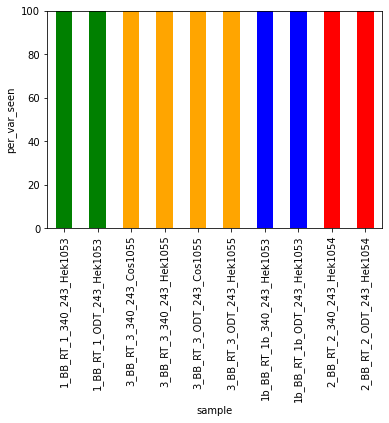

per_reads_passfilt


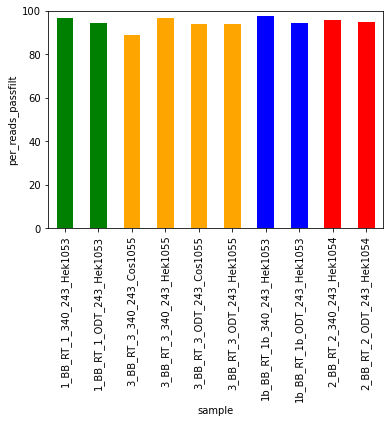

per_bc_passfilt


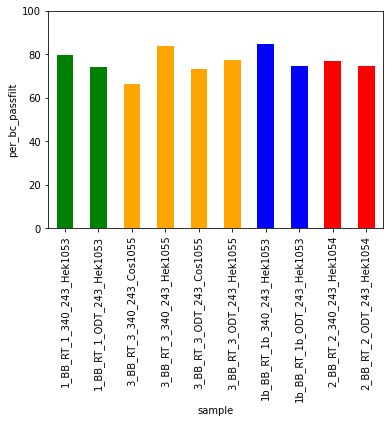

per_usable


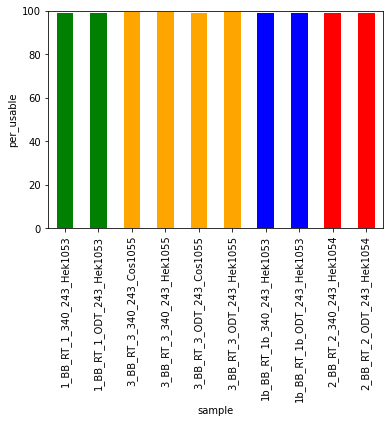

per_unmapped


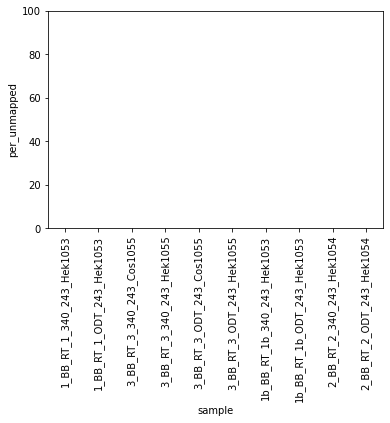

per_badstart


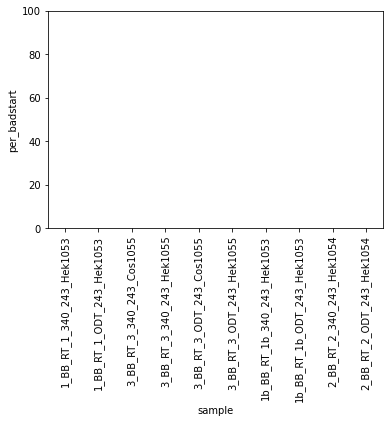

per_badend


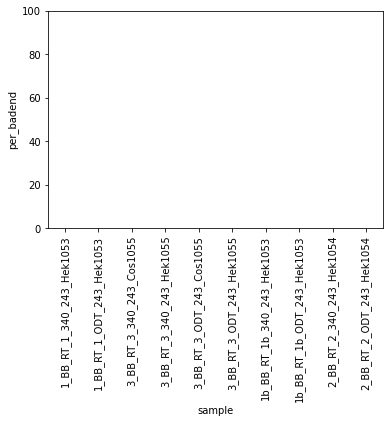

per_softclip


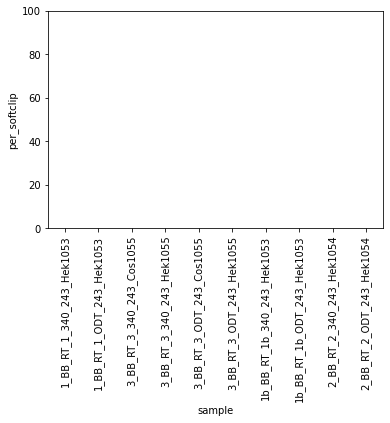

per_otheriso


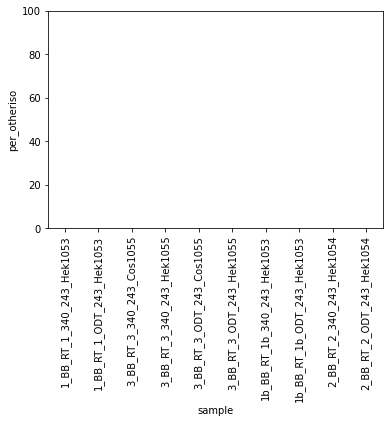

per_sdv


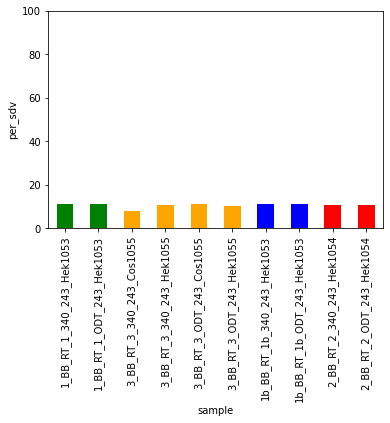

All missing for per_sdv_ex - skipping...
All missing for per_sdv_in - skipping...
All missing for per_acc_used - skipping...
All missing for per_don_used - skipping...


In [11]:
for col in [ col for col in sample_stats if col.startswith( 'per_' ) ]:
    
    if sample_stats[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats,
                                   col,
                                   y_label = col,
                                   y_lim = ( 0, 100 ),
                                    color_col = 'sample_group',
                                    color_dict = colors,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

per_unmapped


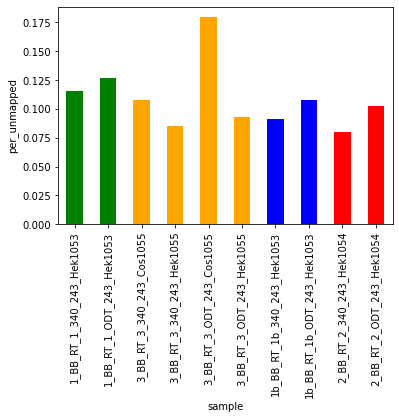

per_badstart


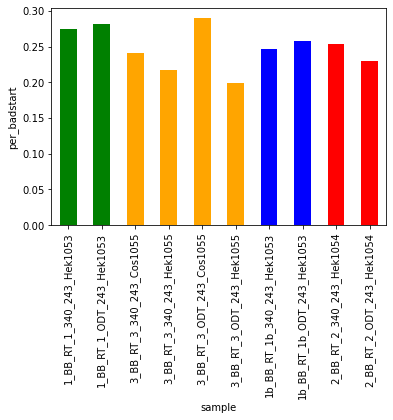

per_badend


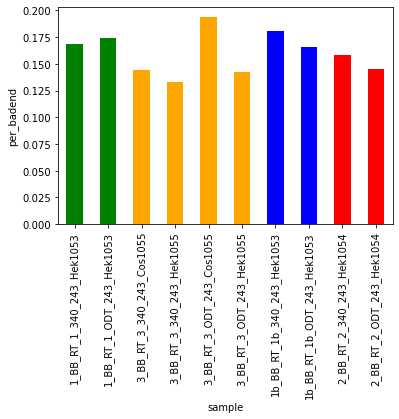

per_softclip


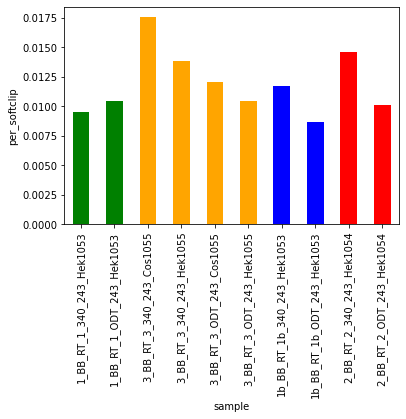

per_otheriso


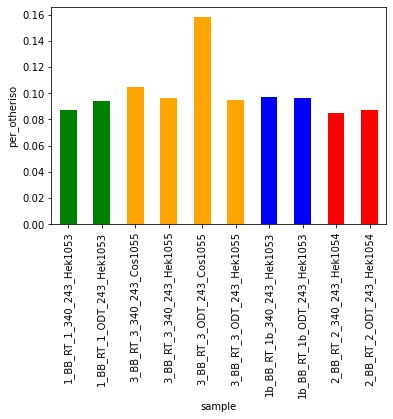

per_sdv


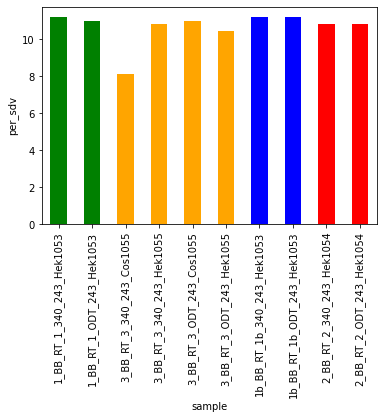

All missing for per_sdv_ex - skipping...
All missing for per_sdv_in - skipping...
All missing for per_acc_used - skipping...
All missing for per_don_used - skipping...


In [12]:
for col in [ col for col in sample_stats if col.startswith( 'per_' ) ]:
    
    if sample_stats[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    elif sample_stats[ col ].max() > 50:
        
        continue
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats,
                                   col,
                                   y_label = col,
                                   #y_lim = ( 0, 100 ),
                                    color_col = 'sample_group',
                                    color_dict = colors,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

psbl_var


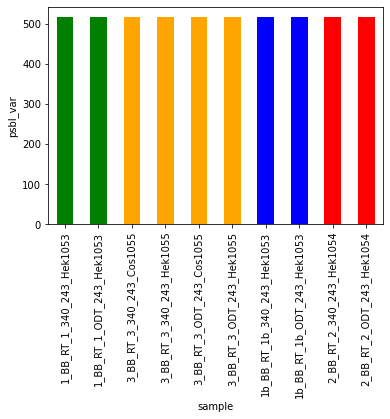

n_var


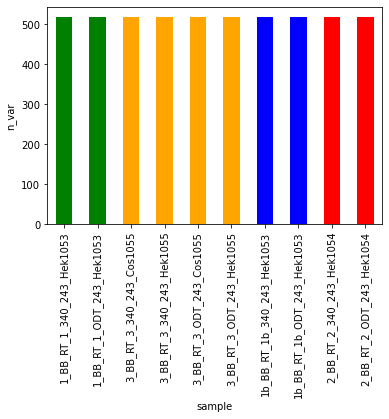

All missing for n_var_ex - skipping...
All missing for n_var_in - skipping...
n_reads


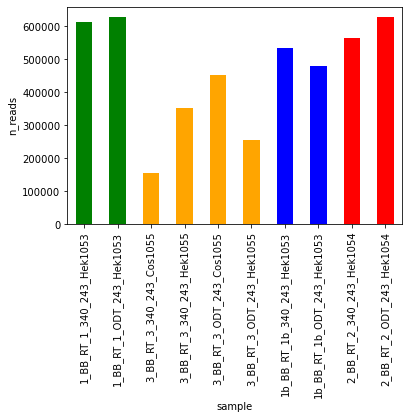

n_reads_passfilt


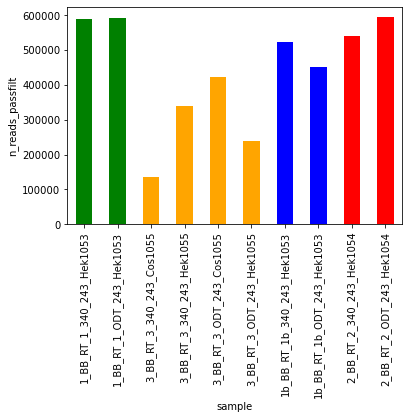

n_usable_reads


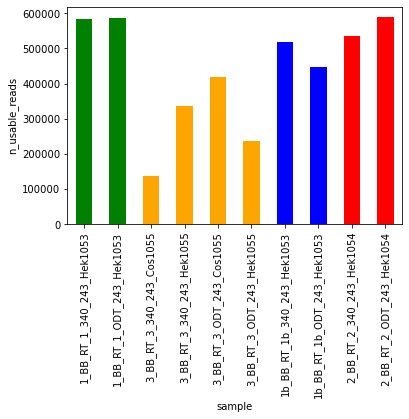

n_bc


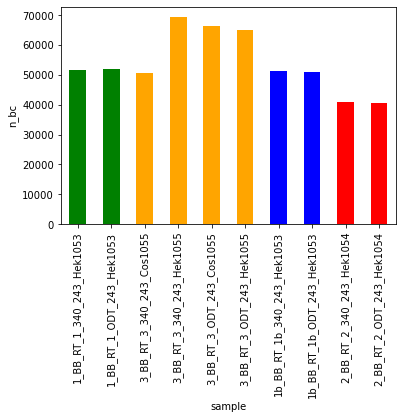

n_bc_passfilt


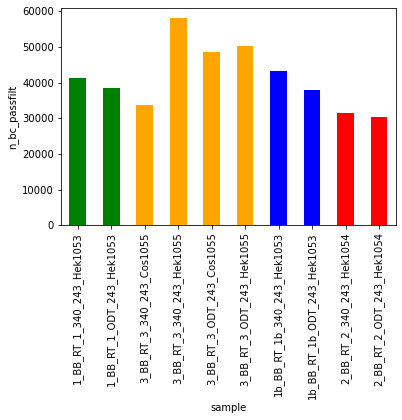

n_unmapped


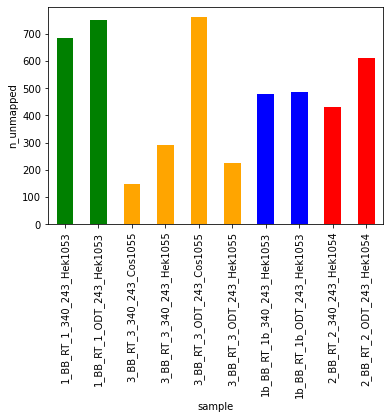

n_badstart


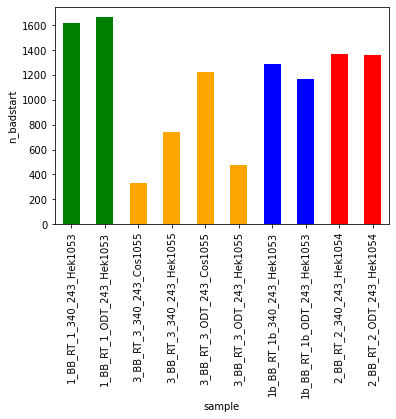

n_badend


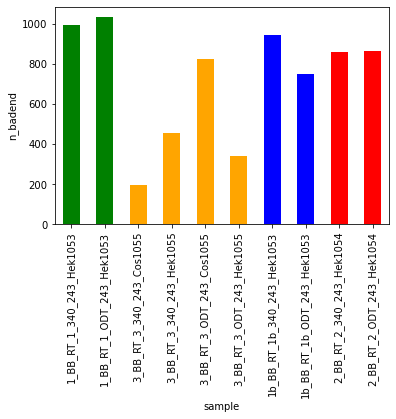

n_softclip


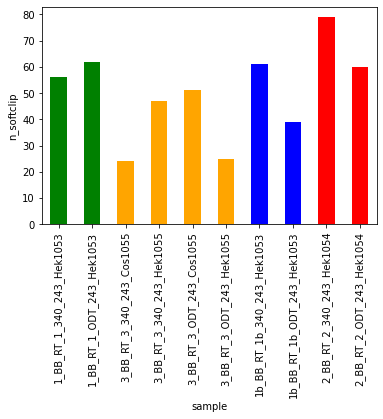

n_otheriso


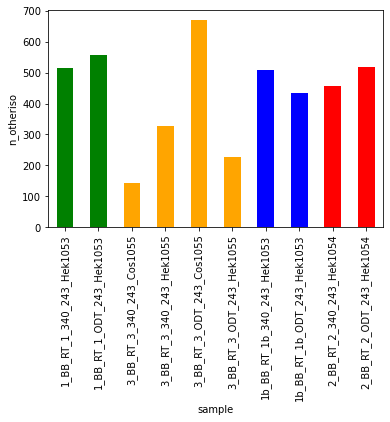

n_sdv


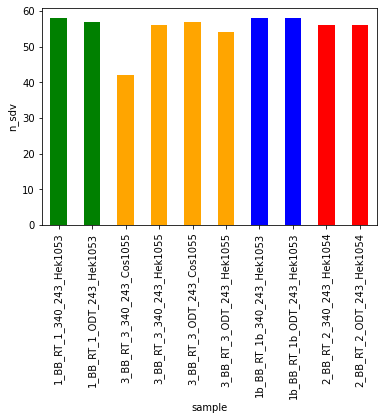

All missing for n_sdv_ex - skipping...
All missing for n_sdv_in - skipping...
All missing for psbl_alt_acc - skipping...
All missing for psbl_alt_don - skipping...
All missing for n_alt_acc - skipping...
All missing for n_alt_don - skipping...
med_wmean_OTHER


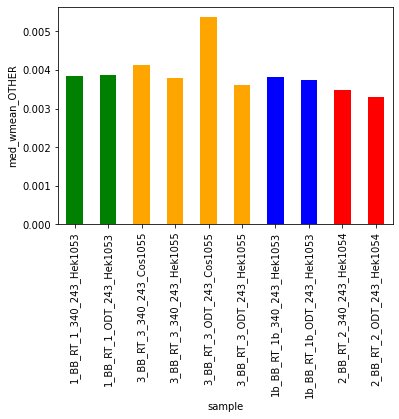

med_wmean_SKIP


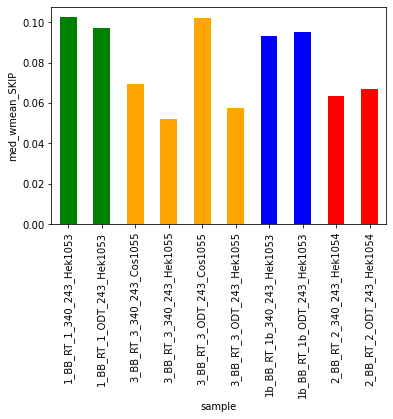

med_wmean_KTS+


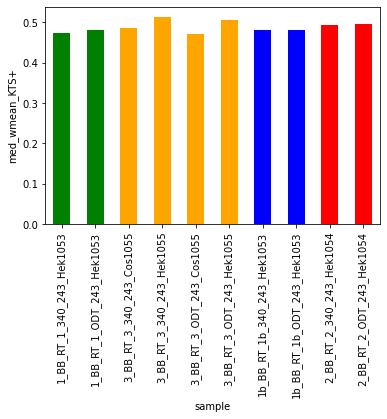

med_wmean_KTS-


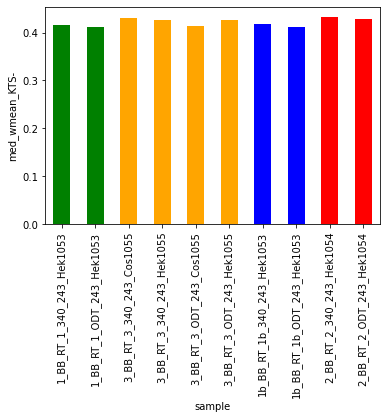

In [13]:
for col in [ col for col in sample_stats if not col.startswith( 'per_' ) ]:
    
    if sample_stats[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    elif 'sample' in col:
        continue
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats,
                                   col,
                                   y_label = col,
                                   #y_lim = ( 0, 100 ),
                                    color_col = 'sample_group',
                                    color_dict = colors,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

med_wmean_OTHER


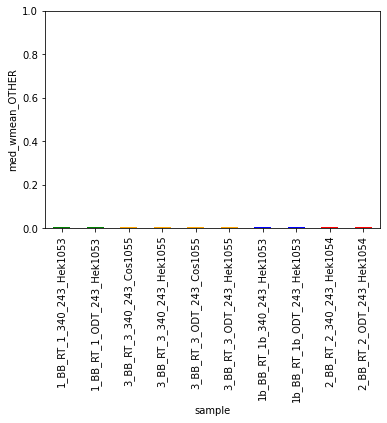

med_wmean_SKIP


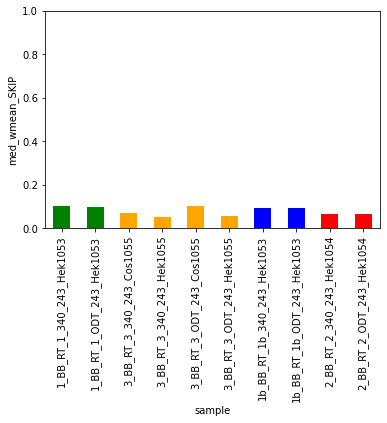

med_wmean_KTS+


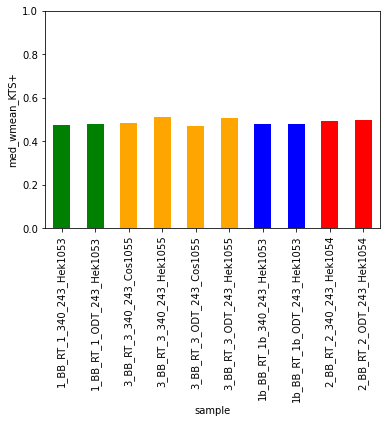

med_wmean_KTS-


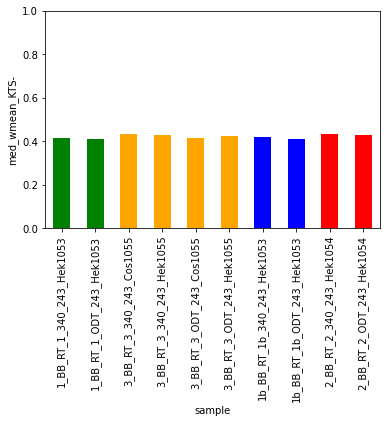

In [14]:
for col in [ col for col in sample_stats if col.startswith( 'med_' ) ]:
    
    if sample_stats[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats,
                                   col,
                                   y_label = col,
                                   y_lim = ( 0, 1 ),
                                    color_col = 'sample_group',
                                    color_dict = colors,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

In [15]:
sample_stats[ 'sample_group_primer' ] = sample_stats[ 'sample' ].apply( lambda x: x.split( '_' )[ -2 ] if 'test' not in x else 'test' )

In [16]:
colors2 = { '243':'green', '335':'red', 'test':'purple' }

med_wmean_OTHER


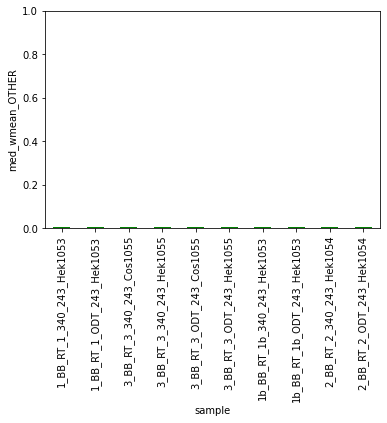

med_wmean_SKIP


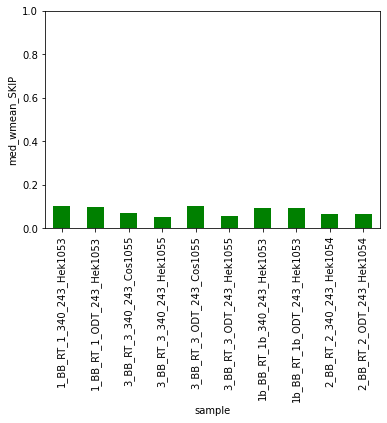

med_wmean_KTS+


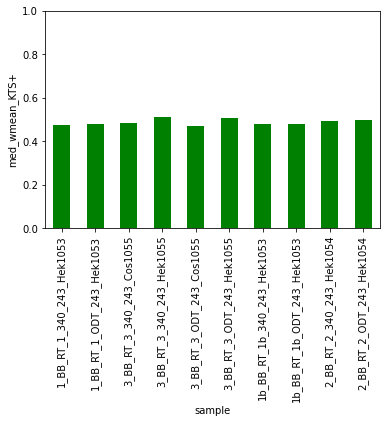

med_wmean_KTS-


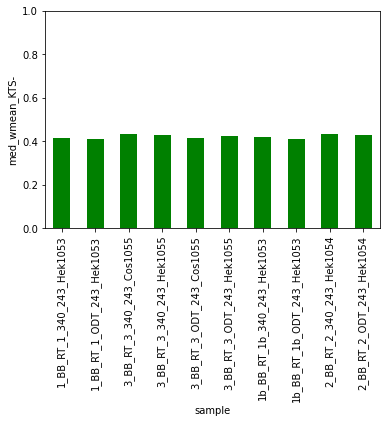

In [17]:
#same as above but colored by primer
for col in [ col for col in sample_stats if col.startswith( 'med_' ) ]:
    
    if sample_stats[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats,
                                   col,
                                   y_label = col,
                                   y_lim = ( 0, 1 ),
                                    color_col = 'sample_group_primer',
                                    color_dict = colors2,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

In [18]:
#seeing a big difference in SKIP - lets only keep 243 samples..
byvartbl_long_filt = byvartbl_long.loc[ byvartbl_long[ 'sample' ].str.contains( '_243_' ) ].copy()

In [19]:
samp_filt_by_rep_fn = {}

for samp in byvartbl_long_filt['sample'].unique().tolist():
    
    if '_test_' in samp:
        rep = 'test'
    else:
        rep = samp.split( '_' )[ 2 ]
        
    if rep in samp_filt_by_rep_fn:
        samp_filt_by_rep_fn[ rep ].append( samp )
    else:
        samp_filt_by_rep_fn[ rep ] = [ samp ]

In [20]:
sample_stats_filt = pp.across_sample_stats( [ byvartbl_long_filt.loc[ ( byvartbl_long_filt.rep == rep ) ] for rep in samp_filt_by_rep_fn ],
                                        samp_filt_by_rep_fn,
                                        [ 'wmean_OTHER', 'wmean_SKIP', 'wmean_KTS+', 'wmean_KTS-' ]
                                       ) 

psbl_var


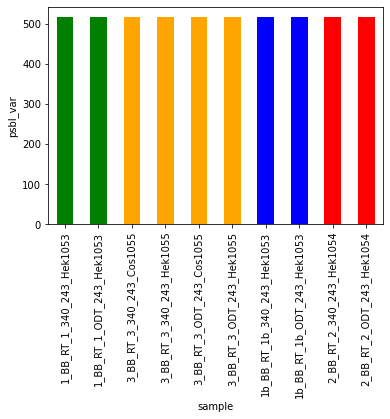

n_var


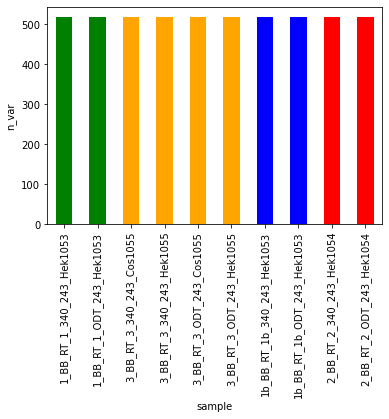

All missing for n_var_ex - skipping...
All missing for n_var_in - skipping...
n_reads


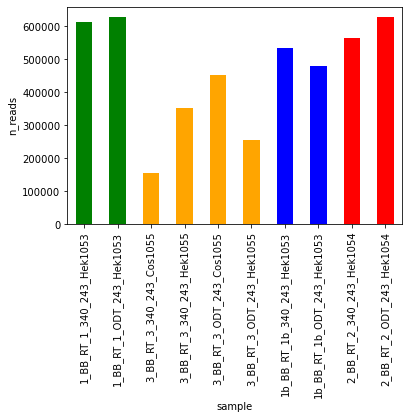

n_reads_passfilt


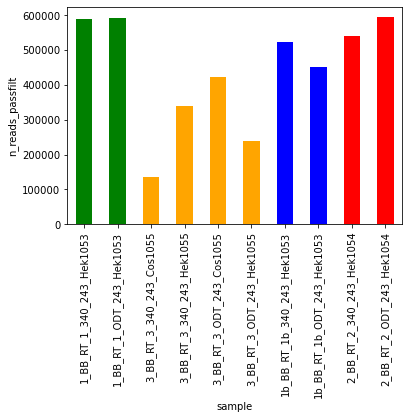

n_usable_reads


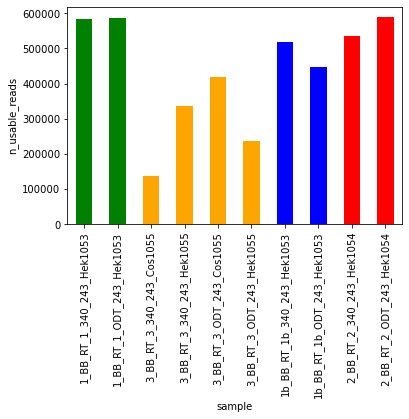

n_bc


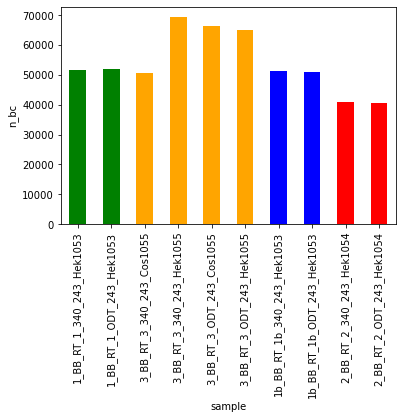

n_bc_passfilt


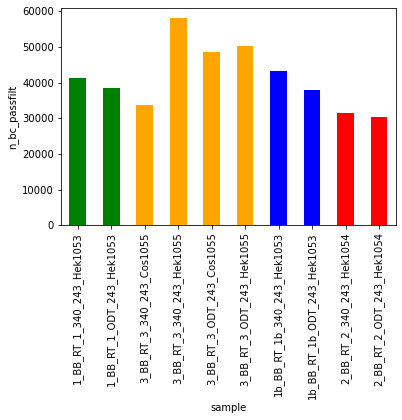

n_unmapped


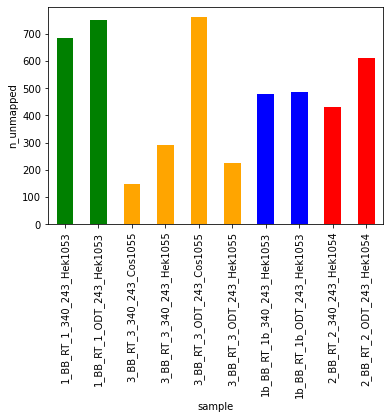

n_badstart


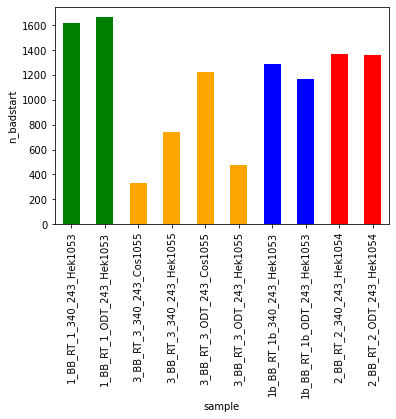

n_badend


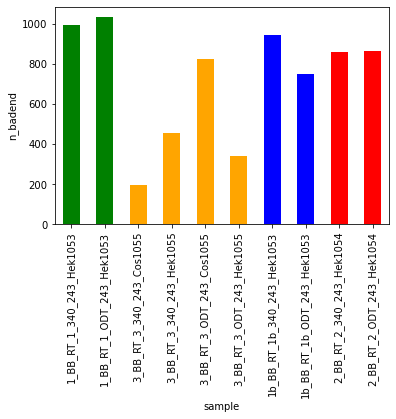

n_softclip


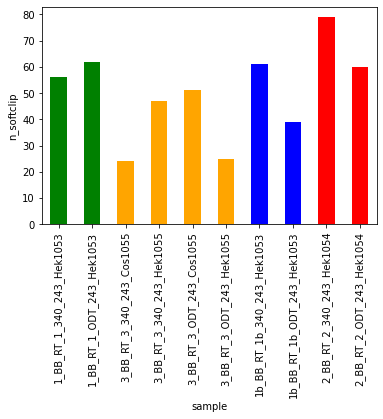

n_otheriso


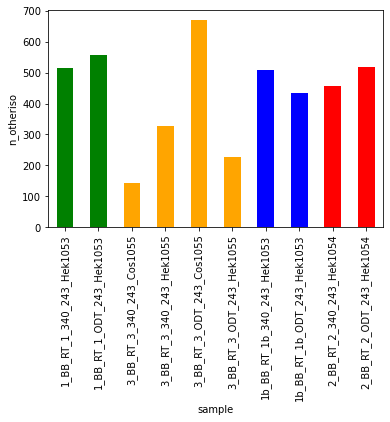

n_sdv


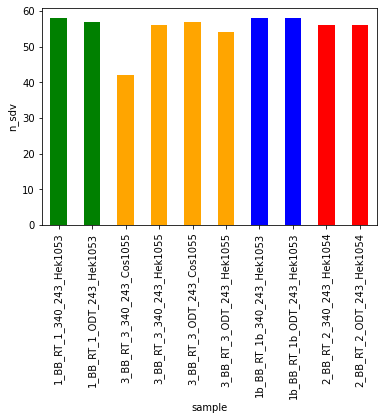

All missing for n_sdv_ex - skipping...
All missing for n_sdv_in - skipping...
All missing for psbl_alt_acc - skipping...
All missing for psbl_alt_don - skipping...
All missing for n_alt_acc - skipping...
All missing for n_alt_don - skipping...
med_wmean_OTHER


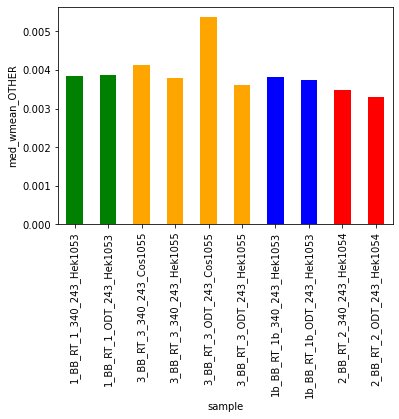

med_wmean_SKIP


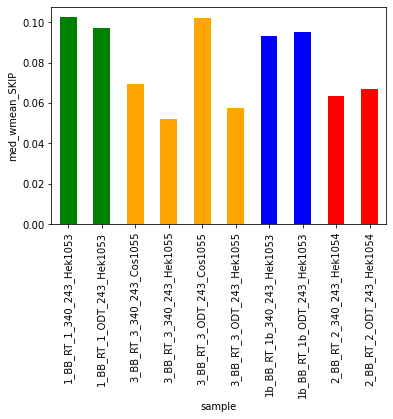

med_wmean_KTS+


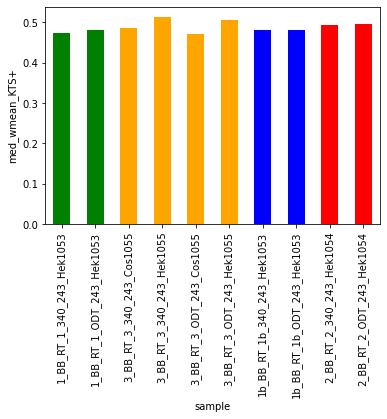

med_wmean_KTS-


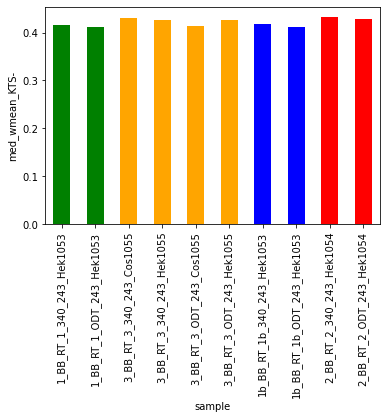

In [21]:
for col in [ col for col in sample_stats_filt if not col.startswith( 'per_' ) ]:
    
    if sample_stats_filt[ col ].notnull().sum() == 0:
        
        print( 'All missing for %s - skipping...' % col )
        
    elif 'sample' in col:
        continue
        
    else:
        
        print( col )
        
        sp.barplot_across_samples( sample_stats_filt,
                                   col,
                                   y_label = col,
                                   #y_lim = ( 0, 100 ),
                                    color_col = 'sample_group',
                                    color_dict = colors,
                                    #title = 'Percent of INTRONIC variants that are splice disrupting by sample' 
                                 )

In [22]:
byvartbl_long_filt.groupby( 'sample' ).n_bc_passfilt.median()

sample
BB_RT_1_340_243_Hek1053      71.0
BB_RT_1_ODT_243_Hek1053      66.0
BB_RT_1b_340_243_Hek1053     74.0
BB_RT_1b_ODT_243_Hek1053     64.5
BB_RT_2_340_243_Hek1054      55.0
BB_RT_2_ODT_243_Hek1054      53.5
BB_RT_3_340_243_Cos1055      59.0
BB_RT_3_340_243_Hek1055     100.0
BB_RT_3_ODT_243_Cos1055      84.0
BB_RT_3_ODT_243_Hek1055      87.0
Name: n_bc_passfilt, dtype: float64

In [23]:
#lets throw out the ones w median BC <= 50
low_bc_samps = byvartbl_long_filt.groupby( 'sample' ).n_bc_passfilt.median().loc[ byvartbl_long_filt.groupby( 'sample' ).n_bc_passfilt.median() <= 50 ].index.tolist()

In [24]:
byvartbl_long_filt2 = byvartbl_long_filt.loc[ byvartbl_long_filt[ 'sample' ].apply( lambda x: x not in low_bc_samps ) ].copy()

In [25]:
byvartbl_allisos = pd.read_table( '/nfs/kitzman2/smithcat/proj/wt1_2022/ex9_data/wt1_ex9_by_var_effects_allisos_snvs-2022-0926.txt' )

In [26]:
bybc_tbl_l = ! ls {bdout}wt1_ex9_*_by_bc_effects_allvars-2022-0926.txt

In [27]:
bybc_tbl_fn = { tbl.split( '/' )[ -1 ].split( '_' )[ 2 ]: pd.read_table( tbl )
                for tbl in bybc_tbl_l }

In [28]:
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ ( bybc_tbl_fn[ lib ].n_variants_passing == 1 ) ].copy()

In [29]:
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ][ 'pos' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: int( x.split( ':' )[ 1 ] ) )
    bybc_tbl_fn[ lib ][ 'ref' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: x.split( ':' )[ 2 ] )
    bybc_tbl_fn[ lib ][ 'alt' ] = bybc_tbl_fn[ lib ].variant_list.apply( lambda x: x.split( ':' )[ 3 ] )

In [30]:
#only want SNV BCs within the region of interest
for lib in bybc_tbl_fn:
    
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].pos >= 1227 ].copy()
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].ref.str.len() == 1 ].copy()
    bybc_tbl_fn[ lib ] = bybc_tbl_fn[ lib ].loc[ bybc_tbl_fn[ lib ].alt.str.len() == 1 ].copy()

In [31]:
#we did <,> 20 bp for POU1F1 but had more intronic context
#here we only have 40 bp on each side - so lets only give 10 bp on each side
bybc_int_tbl_fn = { lib: bybc_tbl_fn[ lib ].loc[ ( bybc_tbl_fn[ lib ].pos < 1257 ) | ( bybc_tbl_fn[ lib ].pos > 1369 ) ].copy()
                    for lib in bybc_tbl_fn }

In [32]:
read_cut_unfilt = pd.read_table( bdout + 'n_bcs_bysamp.2022-0926.txt' )

In [33]:
cut_dict = { samp: cut for samp,cut in zip( read_cut_unfilt[ 'sample' ], read_cut_unfilt[ '95_y' ] ) }

In [34]:
#these were removed so as to not influence the regression - add manually from wt1_byiso.2022-0609
cut_dict[ 'BB_test_Cos1053_JKLab0340_MM1B' ] = 38
cut_dict[ 'BB_test_Cos1053_JKLab0340_MM2B' ] = 89
cut_dict[ 'BB_test_Cos1053_oligodT_MM1B' ] = 30
cut_dict[ 'BB_test_Cos1053_oligodT_MM2B' ] = 92

In [35]:
#same filtering we did during processing to remove low read BCs that could be too influential
bybc_int_tbl_fn_filt_bysamp = { lib: { samp: bybc_int_tbl_fn[ lib ].loc[ ( bybc_int_tbl_fn[ lib ][ 'sample' ] == samp ) & ( bybc_int_tbl_fn[ lib ].usable_reads > cut_dict[ samp ] ) ].copy()
                                       for samp in cut_dict }
                                for lib in bybc_int_tbl_fn }

In [36]:
bybc_int_tbl_fn_filt = { lib: pd.concat( [ bybc_int_tbl_fn_filt_bysamp[ lib ][ samp ] for samp in bybc_int_tbl_fn_filt_bysamp[ lib ] ] )
                         for lib in bybc_int_tbl_fn_filt_bysamp }

In [37]:
byvartbl_long_filt3 = byvartbl_long_filt2.loc[ byvartbl_long_filt2.n_bc_passfilt > 0 ] .copy()

In [38]:
bybc_int_tbl = pd.concat( [ bybc_int_tbl_fn_filt[ lib ] for lib in bybc_int_tbl_fn_filt ] )

In [39]:
byvartbl_long_filt3[ 'wmean_KTS_+_ratio_log2' ] = np.log2( ( byvartbl_long_filt3[ 'wmean_KTS+' ] + .001 ) / ( byvartbl_long_filt3[ 'wmean_KTS-' ] + .001 ) )

In [40]:
bybc_int_tbl[ 'KTS_+_ratio_log2_psi' ] = np.log2( ( bybc_int_tbl[ 'KTS+_psi' ] + .001 ) / ( bybc_int_tbl[ 'KTS-_psi' ] + .001 ) )

In [41]:
iso_names = [ 'KTS_+_ratio_log2', 'SKIP', 'OTHER' ]

In [42]:
%%time
byvartbl_long_bs = pd.concat( [ pp.bootstrap_varsp_null_distribution( bybc_int_tbl.loc[ bybc_int_tbl[ 'sample' ] == samp ].set_index( 'barcode' ),
                                                                      byvartbl_long_filt3.loc[ ( byvartbl_long_filt3[ 'sample' ] == samp ) ],
                                                                      iso_names = iso_names )
                              for samp in byvartbl_long_filt3[ 'sample' ].unique().tolist() ],
                              ignore_index = True )

done
done
done
done
done
done
done
done
done
done
CPU times: user 5.42 s, sys: 56 ms, total: 5.47 s
Wall time: 5.47 s


In [43]:
byvartbl_long_bs = pp.compute_null_zscores( byvartbl_long_bs,
                                            'bs_null', 
                                             iso_names )

In [44]:
%%time
byvartbl_long_bs = pd.concat( [ pp.compute_fold_change( byvartbl_long_bs.loc[ byvartbl_long_bs[ 'sample' ] == samp ],
                                                        'wmean_bs_null_',
                                                         'wmean_') 
                                                        for samp in byvartbl_long_bs[ 'sample' ].unique().tolist() ],
                                                        ignore_index = True ).sort_values( by = 'pos' )

CPU times: user 33.9 ms, sys: 742 µs, total: 34.6 ms
Wall time: 34 ms


In [45]:
for iso in iso_names:
        
        byvartbl_long_bs[ 'wmean_diff_' + iso ] = byvartbl_long_bs[ 'wmean_' + iso ] - byvartbl_long_bs[ 'wmean_bs_null_' + iso ]

In [46]:
bonfer = .05 / ( byvartbl_long_bs.groupby( 'sample' ).size().max() )

In [47]:
ss.norm.ppf( 1 - bonfer )

3.7279414746553314

In [48]:
byvartbl_long_bs[ 'sdv_SKIP' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_SKIP' ] >= .2 )

In [49]:
byvartbl_long_bs[ 'sdv_OTHER' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_OTHER' ] >= .2 )

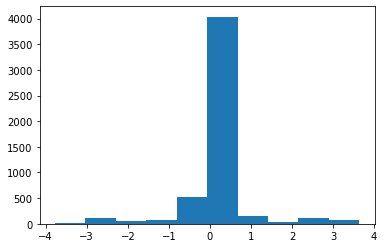

In [50]:
plt.hist( byvartbl_long_bs[ 'wmean_KTS_+_ratio_log2' ] )

plt.show()

In [51]:
byvartbl_long_bs[ 'sdv_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_long_bs[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( ( byvartbl_long_bs[ 'wmean_KTS_+_ratio_log2' ] >= 1.5 ) | ( byvartbl_long_bs[ 'wmean_KTS_+_ratio_log2' ] <= -1 ) )

In [52]:
byvartbl_long_bs[ 'sdv' ] = byvartbl_long_bs[ [ col for col in byvartbl_long_bs if 'sdv_' in col ] ].any( axis = 1 )

In [53]:
byvartbl_long_bs[ 'intmed_SKIP' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_SKIP' ] >= .1 )

In [54]:
byvartbl_long_bs[ 'intmed_OTHER' ] = ( byvartbl_long_bs[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_long_bs[ 'wmean_diff_OTHER' ] >= .1 )

In [55]:
byvartbl_long_bs[ 'intmed_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_long_bs[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                                 & ( ( byvartbl_long_bs[ 'wmean_KTS_+_ratio_log2' ] >= 1 ) | ( byvartbl_long_bs[ 'wmean_KTS_+_ratio_log2' ] <= -.5 ) )

In [56]:
byvartbl_long_bs[ 'intmed' ] = byvartbl_long_bs[ [ col for col in byvartbl_long_bs if 'intmed_' in col ] ].any( axis = 1 )

In [57]:
byvartbl_wide = mbcs.combine_rep_pervartbls_wide( [ byvartbl_long_bs.loc[ byvartbl_long_bs[ 'sample' ] == samp ][ [ col for col in byvartbl_long_bs if col != 'sample' and col != 'rep' ] ]
                                                    for samp in byvartbl_long_bs[ 'sample' ].unique() ],
                                                  [ samp for samp in byvartbl_long_bs[ 'sample' ].unique() ],
                                                  indexcols=[ 'chrom','pos','ref','ref_c','alt','alt_c','varlist','hg19_pos','hgvs_pos','exon_num' ], 
                                                  group_cols_by_samp = True )

In [58]:
byvartbl_wide

,chrom,pos,ref,ref_c,alt,alt_c,varlist,hg19_pos,hgvs_pos,exon_num,...,BB_RT_1_340_243_Hek1053_intmed,BB_RT_3_340_243_Hek1055_intmed,BB_RT_2_340_243_Hek1054_intmed,BB_RT_1_ODT_243_Hek1053_intmed,BB_RT_1b_ODT_243_Hek1053_intmed,BB_RT_3_340_243_Cos1055_intmed,BB_RT_2_ODT_243_Hek1054_intmed,BB_RT_1b_340_243_Hek1053_intmed,BB_RT_3_ODT_243_Cos1055_intmed,BB_RT_3_ODT_243_Hek1055_intmed
0,jkp815,1227,G,C,A,T,jkp815:1227:C:T,32413650,c.1355-40,9,...,False,False,False,False,False,False,False,False,False,False
1,jkp815,1227,G,C,C,G,jkp815:1227:C:G,32413650,c.1355-40,9,...,False,False,False,False,False,False,False,False,False,False
2,jkp815,1227,G,C,T,A,jkp815:1227:C:A,32413650,c.1355-40,9,...,False,False,False,False,False,False,False,False,False,False
3,jkp815,1228,T,A,A,T,jkp815:1228:A:T,32413649,c.1355-39,9,...,False,False,False,False,False,False,False,False,False,False
4,jkp815,1228,T,A,C,G,jkp815:1228:A:G,32413649,c.1355-39,9,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,jkp815,1398,A,T,G,C,jkp815:1398:T:C,32413479,c.1447+39,9,...,False,False,False,False,False,False,False,False,False,False
514,jkp815,1398,A,T,T,A,jkp815:1398:T:A,32413479,c.1447+39,9,...,False,False,False,False,False,False,False,False,False,False
515,jkp815,1399,A,T,C,G,jkp815:1399:T:G,32413478,c.1447+40,9,...,False,False,False,False,False,False,False,False,False,False
516,jkp815,1399,A,T,G,C,jkp815:1399:T:C,32413478,c.1447+40,9,...,False,False,False,False,False,False,False,False,False,False


In [59]:
byvartbl_wide = mbcs.create_variables_across_samples( byvartbl_wide,
                                                 [ samp for samp in byvartbl_long_bs[ 'sample' ].unique() ],
                                                 mean_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ],
                                                 median_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ],
                                                 sum_cols = [ 'sum_reads','sum_reads_passfilt', ],
                                                 max_cols = [ 'n_bc','n_bc_passfilt', 'sum_reads','sum_reads_passfilt', ] )

In [60]:
byvartbl_wide = mbcs.compute_bc_weighted_psi( byvartbl_wide,
                                         [ samp for samp in byvartbl_long_bs[ 'sample' ].unique() ],
                                         [ 'KTS+','KTS-','SKIP','OTHER' ],
                                         'n_bc_passfilt',
                              )

In [61]:
byvartbl_wide[ 'KTS_+_ratio_log2' ] = np.log2( ( byvartbl_wide[ 'wmean_KTS+' ] + .001 ) / ( byvartbl_wide[ 'wmean_KTS-' ] + .001 ) )

In [62]:
byvartbl_wide[ 'exon' ] = ( byvartbl_wide.pos >= 1267 ) & ( byvartbl_wide.pos <= 1359 ) 
byvartbl_wide[ 'intron' ] = ( ( byvartbl_wide.pos < 1267 ) | ( byvartbl_wide.pos > 1359 ) )

In [63]:
for iso in iso_names:
    
    byvartbl_wide[ 'fc_' + iso ] = byvartbl_wide[ [ col for col in byvartbl_wide.columns if '_fc_' + iso in col ] ].median( axis = 1 )

In [64]:
for iso in iso_names:
    
    byvartbl_wide[ 'wmean_bs_null_' + iso ] = byvartbl_wide[ [ col for col in byvartbl_wide.columns if '_wmean_bs_null_' + iso in col ] ].median( axis = 1 )

In [65]:
for iso in iso_names:
    
    byvartbl_wide[ 'wmean_diff_' + iso ] = byvartbl_wide[ [ col for col in byvartbl_wide.columns if '_wmean_diff_' + iso in col ] ].median( axis = 1 )

In [66]:
for iso in iso_names:
    
    byvartbl_wide[ 'wmean_' + iso ] = byvartbl_wide[ [ col for col in byvartbl_wide.columns if '_wmean_' + iso in col ] ].median( axis = 1 )

In [67]:
byvartbl_wide = pp.stouffers_z( byvartbl_wide,
                                  iso_names,
                                  zcol = 'zwmean_bs_null_')

In [68]:
byvartbl_wide[ 'sdv_SKIP' ] = ( byvartbl_wide[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide[ 'wmean_diff_SKIP' ] >= .2 )

In [69]:
byvartbl_wide[ 'sdv_OTHER' ] = ( byvartbl_wide[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide[ 'wmean_diff_OTHER' ] >= .2 )

In [70]:
byvartbl_wide[ 'sdv_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_wide[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                          & ( ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] >= 1.5 ) | ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] <= -1 ) )

In [71]:
byvartbl_wide[ 'intmed_SKIP' ] = ( byvartbl_wide[ 'zwmean_bs_null_SKIP' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide[ 'wmean_diff_SKIP' ] >= .1 )

In [72]:
byvartbl_wide[ 'intmed_OTHER' ] = ( byvartbl_wide[ 'zwmean_bs_null_OTHER' ] >= ss.norm.ppf( 1 - bonfer ) ) \
                                 & ( byvartbl_wide[ 'wmean_diff_OTHER' ] >= .1 )

In [73]:
byvartbl_wide[ 'intmed_KTS_+_ratio_log2' ] = ( np.abs( byvartbl_wide[ 'zwmean_bs_null_KTS_+_ratio_log2' ] ) >= ss.norm.ppf( 1 - bonfer ) ) \
                                             & ( ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] >= 1 ) | ( byvartbl_wide[ 'wmean_KTS_+_ratio_log2' ] <= -.5 ) )

In [74]:
byvartbl_wide[ 'sdv' ] = byvartbl_wide[ [ 'sdv_' + iso for iso in iso_names ] ].any( axis = 'columns' )

In [75]:
byvartbl_wide[ 'intmed' ] = ( byvartbl_wide[ [ 'intmed_' + iso for iso in iso_names ] ].any( axis = 'columns' ) ) & ~( byvartbl_wide.sdv )

In [76]:
byvartbl_wide[ 'sdv_sum' ] = byvartbl_wide[ [ samp + '_sdv' for samp in byvartbl_long_bs[ 'sample' ].unique() ] ].sum( axis = 1 )

In [77]:
byvartbl_wide[ 'intmed_sum' ] = byvartbl_wide[ [ samp + '_intmed' for samp in byvartbl_long_bs[ 'sample' ].unique() ] ].sum( axis = 1 )

In [78]:
byvartbl_wide[ 'sdv_ss' ] = ( byvartbl_wide.sdv ) \
                            & ( ( byvartbl_wide.pos == 1265 ) | ( byvartbl_wide.pos == 1266 ) \
                                | ( byvartbl_wide.pos == 1351 ) | ( byvartbl_wide.pos == 1352 ) \
                                | ( byvartbl_wide.pos == 1360 ) | ( byvartbl_wide.pos == 1361 ) ) 

In [79]:
byvartbl_wide[ 'intmed_ss' ] = ( byvartbl_wide.intmed ) \
                            & ( ( byvartbl_wide.pos == 1265 ) | ( byvartbl_wide.pos == 1266 ) \
                                | ( byvartbl_wide.pos == 1351 ) | ( byvartbl_wide.pos == 1352 ) \
                                | ( byvartbl_wide.pos == 1360 ) | ( byvartbl_wide.pos == 1361 ) ) 

In [80]:
byvartbl_wide[ 'sdv_exon' ] = ( byvartbl_wide.exon ) & ( byvartbl_wide.sdv )
byvartbl_wide[ 'sdv_intron' ] = ( byvartbl_wide.intron ) & ( byvartbl_wide.sdv )

In [81]:
byvartbl_wide[ 'intmed_exon' ] = ( byvartbl_wide.exon ) & ( byvartbl_wide.intmed )
byvartbl_wide[ 'intmed_intron' ] = ( byvartbl_wide.intron ) & ( byvartbl_wide.intmed )

In [82]:
clinvar = pd.read_table( '/nfs/kitzman2/smithcat/proj/wt1_2022/clinvar/clinvar_wt1_ex9.txt' )

In [83]:
clinvar

,hg19_pos,ref,alt,CLNDISDB,ALLELEID,clinvar_conflicts,RS,clinvar_mol_consequence,clinvar_rev_status,variant_id,clinvar_origin,clinvar_var_type,clinvar_interp,clinvar_lab,clinvar_dx,allele_freq_exac,allele_freq_tgp,gene_name_id,seq_ontol,allele_freq_esp
0,32413498,G,A,"('MONDO:MONDO:0007635', 'MeSH:D052159', 'MedGe...",1654816,NaN,NaN,SO:0001627|intron_variant,"('criteria_provided', '_single_submitter')",NC_000011.9:g.32413498G>A,1,single_nucleotide_variant,Likely_benign,NaN,Frasier_syndrome|Wilms_tumor_1|11p_partial_mon...,NaN,NaN,WT1:7490,SO:0001483,NaN
1,32413499,T,C,"('MONDO:MONDO:0007635', 'MeSH:D052159', 'MedGe...",1544128,NaN,NaN,SO:0001627|intron_variant,"('criteria_provided', '_single_submitter')",NC_000011.9:g.32413499T>C,1,single_nucleotide_variant,Likely_benign,NaN,Frasier_syndrome|Wilms_tumor_1|11p_partial_mon...,NaN,NaN,WT1:7490,SO:0001483,NaN
2,32413505,A,G,"('MONDO:MONDO:0007635', 'MeSH:D052159', 'MedGe...",1648037,NaN,NaN,SO:0001627|intron_variant,"('criteria_provided', '_single_submitter')",NC_000011.9:g.32413505A>G,1,single_nucleotide_variant,Likely_benign,NaN,Frasier_syndrome|Wilms_tumor_1|11p_partial_mon...,NaN,NaN,WT1:7490,SO:0001483,NaN
3,32413511,T,C,"('MONDO:MONDO:0007635', 'MeSH:D052159', 'MedGe...",1142226,NaN,NaN,SO:0001627|intron_variant,"('criteria_provided', '_single_submitter')",NC_000011.9:g.32413511T>C,1,single_nucleotide_variant,Likely_benign,NaN,Frasier_syndrome|Wilms_tumor_1|11p_partial_mon...,NaN,NaN,WT1:7490,SO:0001483,NaN
4,32413512,A,T,"('MONDO:MONDO:0007635', 'MeSH:D052159', 'MedGe...",18525,NaN,5.877766e+08,SO:0001627|intron_variant,no_assertion_criteria_provided,NC_000011.9:g.32413512A>T,1,single_nucleotide_variant,Pathogenic,OMIM_Allelic_Variant:607102.0019,Frasier_syndrome,NaN,NaN,WT1:7490,SO:0001483,NaN
5,32413513,C,T,"('MONDO:MONDO:0007635', 'MeSH:D052159', 'MedGe...",18532,NaN,5.877766e+08,SO:0001627|intron_variant,"('criteria_provided', '_multiple_submitters', ...",NC_000011.9:g.32413513C>T,33,single_nucleotide_variant,Pathogenic,OMIM_Allelic_Variant:607102.0009|OMIM_Allelic_...,('Frasier_syndrome|Wilms_tumor_1|11p_partial_m...,NaN,NaN,WT1:7490,SO:0001483,NaN
6,32413514,G,A,"('Human_Phenotype_Ontology:HP:0012593', 'MedGe...",18539,NaN,5.877766e+08,SO:0001627|intron_variant,"('criteria_provided', '_multiple_submitters', ...",NC_000011.9:g.32413514G>A,1,single_nucleotide_variant,Pathogenic/Likely_pathogenic,OMIM_Allelic_Variant:607102.0018,('Nephrotic_range_proteinuria|Frasier_syndrome...,NaN,NaN,WT1:7490,SO:0001483,NaN
7,32413515,C,T,"('MONDO:MONDO:0007635', 'MeSH:D052159', 'MedGe...",1357960,NaN,NaN,SO:0001627|intron_variant,"('criteria_provided', '_single_submitter')",NC_000011.9:g.32413515C>T,1,single_nucleotide_variant,Uncertain_significance,NaN,Frasier_syndrome|Wilms_tumor_1|11p_partial_mon...,NaN,NaN,WT1:7490,SO:0001483,NaN
8,32413516,A,G,"('MONDO:MONDO:0007635', 'MeSH:D052159', 'MedGe...",940994,NaN,1.851829e+09,"('SO:0001575|splice_donor_variant', 'SO:000162...","('criteria_provided', '_single_submitter')",NC_000011.9:g.32413516A>G,1,single_nucleotide_variant,Likely_pathogenic,NaN,Frasier_syndrome|Wilms_tumor_1|11p_partial_mon...,NaN,NaN,WT1:7490,SO:0001483,NaN
9,32413528,T,C,"('Human_Phenotype_Ontology:HP:0000062', 'Human...",969548,Pathogenic(1)|_Uncertain_significance(1),1.851830e+09,"('SO:0001619|non-coding_transcript_variant', '...",no_assertion_criteria_provided,NC_000011.9:g.32413528T>C,32,single_nucleotide_variant,Conflicting_interpretations_of_pathogenicity,NaN,Ambiguous_genitalia|Disorder_of_sexual_differe...,NaN,NaN,WT1:7490,SO:0001483,NaN


In [84]:
byvartbl_wide = pp.merge_clinvar( byvartbl_wide,
                                  clinvar )

In [85]:
byvartbl_wide[ 'clinvar_interp' ] = byvartbl_wide.clinvar_interp.fillna( '' )

In [86]:
byvartbl_wide[ 'clinvar_rev_status' ] = byvartbl_wide.clinvar_rev_status.fillna( '' )

In [87]:
byvartbl_wide[ 'clinvar_rev_status' ] = [ rev.split( ',' )[ 1 ].replace( '\'', '' )[ 2: -1 ] if '(' in rev \
                                          else rev for rev in byvartbl_wide.clinvar_rev_status ]

In [88]:
lit = pd.read_table( bdout + 'wt1_ex9_variant_lit.2022-0926.txt' )

In [89]:
lit[ 'In ClinVar?' ].unique()

array(['Yes', 'No'], dtype=object)

In [90]:
lit = lit.loc[ lit[ 'In ClinVar?' ] == 'No' ].copy()

In [91]:
lit = lit.rename( columns = { 'cDNA ref': 'ref_c',
                              'cDNA alt': 'alt_c',
                              'cDNA_pos': 'hgvs_pos',
                              'source where variant were reported': 'lit_source',
                              'Interpretation_ACMG_Varsome': 'acmg_interp' } )

In [92]:
lit[ 'ref' ] = [ css.rev_complement( r ) for r in lit.ref_c ]

In [93]:
lit[ 'alt' ] = [ css.rev_complement( a ) for a in lit.alt_c ]

In [94]:
lit = lit[ [ 'hg19_pos', 'hgvs_pos', 'ref', 'alt', 'ref_c', 'alt_c', 'lit_source', 'Human disease reported in HGMD', 'acmg_interp' ]].copy()

In [95]:
#ran this as a left merge bc one of the lit variants is too far into US intron (c.1355-87)
idx_cols = [ 'hgvs_pos', 'hg19_pos', 'ref', 'alt', 'ref_c', 'alt_c' ]

byvartbl_wide = byvartbl_wide.set_index( idx_cols ).merge( lit.set_index( idx_cols ),
                                                           how = 'left',
                                                           left_index = True,
                                                           right_index = True ).reset_index()

In [96]:
lit

,hg19_pos,hgvs_pos,ref,alt,ref_c,alt_c,lit_source,Human disease reported in HGMD,acmg_interp
1,32413638,c.1355-28,G,A,C,T,HGMD,SRNS?,Likely benign
5,32413517,c.1447+1,C,T,G,A,HGMD,Frasier syndrome,Pathogenic
6,32413517,c.1447+1,C,G,G,C,HGMD,FSGS,Pathogenic
9,32413515,c.1447+3,C,A,G,T,Kireport,NaN,Pathogenic
12,32413513,c.1447+5,C,A,G,T,HGMD,Frasier syndrome,Pathogenic


In [97]:
byvartbl_wide[ 'acmg_interp' ] = byvartbl_wide.acmg_interp.fillna( '' )

In [98]:
byvartbl_wide[ 'acmg' ] = byvartbl_wide[ 'acmg_interp' ] != ''

In [99]:
byvartbl_wide[ 'lit_var' ] = ( ( byvartbl_wide.clinvar ) | ( byvartbl_wide.acmg ) )

In [100]:
byvartbl_wide.lit_var.sum()

48

In [101]:
byvartbl_wide.clinvar_interp.unique()

array(['', 'Likely_benign', 'Pathogenic', 'Uncertain_significance',
       'Conflicting_interpretations_of_pathogenicity',
       'Likely_pathogenic', 'Pathogenic/Likely_pathogenic'], dtype=object)

In [102]:
byvartbl_wide.acmg_interp.unique()

array(['', 'Likely benign', 'Pathogenic'], dtype=object)

In [103]:
byvartbl_wide[ 'lit_interp' ] = [ 'VUS/Conflicting (CV)' if clin == 'Uncertain_significance' or clin == 'Conflicting_interpretations_of_pathogenicity' \
                                  else 'Benign/Likely_benign (CV/ACMG)' if 'nign' in clin or 'nign' in acmg \
                                  else 'Pathogenic/Likely_pathogenic (CV)' if 'ogenic' in clin \
                                  else 'Pathogenic/Likely_pathogenic (ACMG)' if 'ogenic' in acmg \
                                  else ''
                                  for clin,acmg in zip( byvartbl_wide.clinvar_interp, byvartbl_wide.acmg_interp ) ]

In [104]:
gnomad2 = pd.read_table( bdout + 'gnomad_v2_wt1.txt' )

In [105]:
gnomad3 = pd.read_table( bdout + 'gnomad_v3_wt1.txt' )

In [106]:
byvartbl_wide = gn.merge_data_gnomad( byvartbl_wide,
                                      gnomad2,
                                      indexcols = [ 'hg19_pos', 'ref', 'alt' ],
                                      suffix = 'v2' )

In [107]:
byvartbl_wide = gn.merge_data_gnomad( byvartbl_wide,
                                       gnomad3[ [ 'chrom', 'hg19_pos', 'ref', 'alt', 'n_alt', 'n_allele', 'n_homo', 'af' ] ] ,
                                       indexcols = [ 'hg19_pos', 'ref', 'alt' ],
                                       suffix = 'v3' )

In [108]:
byvartbl_wide[ 'gnomad' ] = ( byvartbl_wide.n_alt_v2 > 0 ) | ( byvartbl_wide.n_alt_v3 > 0 )

In [109]:
byvartbl_wide.gnomad.sum()

23

In [110]:
byvartbl_wide.groupby( 'lit_interp' ).gnomad.sum()

lit_interp
                                       14
Benign/Likely_benign (CV/ACMG)          6
Pathogenic/Likely_pathogenic (ACMG)     0
Pathogenic/Likely_pathogenic (CV)       2
VUS/Conflicting (CV)                    1
Name: gnomad, dtype: int64

In [111]:
byvartbl_wide.groupby( 'sdv' ).gnomad.sum()

sdv
False    23
True      0
Name: gnomad, dtype: int64

In [112]:
byvartbl_wide.groupby( 'intmed' ).gnomad.sum()

intmed
False    23
True      0
Name: gnomad, dtype: int64

In [113]:
byvartbl_wide.loc[ byvartbl_wide.hgvs_pos.str.contains( '\+7' ) ]

,hg19_pos,ref,alt,hgvs_pos,ref_c,alt_c,chrom,pos,varlist,exon_num,...,lit_interp,n_alt_v2,n_allele_v2,n_homo_v2,af_v2,n_alt_v3,n_allele_v3,n_homo_v3,af_v3,gnomad
416,32413511,T,G,c.1447+7,A,C,jkp815,1366,jkp815:1366:A:C,9,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
417,32413511,T,A,c.1447+7,A,T,jkp815,1366,jkp815:1366:A:T,9,...,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
418,32413511,T,C,c.1447+7,A,G,jkp815,1366,jkp815:1366:A:G,9,...,Benign/Likely_benign (CV/ACMG),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False


In [114]:
#this was computed in jkp1053_byiso.2022-0428
splai = pd.read_table( '/nfs/kitzman2/smithcat/proj/spliceAI/splai_output/wt1_ex9.txt',
                       dtype = { 'chrom': object } )

In [115]:
byvartbl_wide[ 'chrom' ] = '11'

In [116]:
byvartbl_wide = sm.merge_splai( byvartbl_wide,
                                splai )

In [117]:
#this was computed in jkp1053_byiso.2022-0428
splai_wt = pd.read_table( '/nfs/kitzman2/smithcat/proj/spliceAI/splai_output/wt1_ex9_wt_ss_probs.txt',
                       dtype = { 'chrom': object } ).rename( columns = { 'wt_acc_pr': 'splai_wt_acc', 'wt_don_pr': 'splai_wt_don', 'pos': 'hg19_pos' } )

In [118]:
byvartbl_wide = byvartbl_wide.set_index( [ 'hg19_pos', 'ref', 'chrom' ] ).merge( splai_wt.set_index( [ 'hg19_pos', 'ref', 'chrom' ] ),
                                                                        how = 'left', 
                                                                        left_index = True,
                                                                        right_index = True ).reset_index()

In [119]:
#this was computed in jkp1053_byiso.2022-0428
splai_ss_pr = pd.read_table( '/nfs/kitzman2/smithcat/proj/spliceAI/splai_output/wt1_ex9_ss_probs.txt',
                             dtype = { 'chrom': object } ).rename( columns = { 'ss_don_prob_32413527': 'splai_KTS-',
                                                                               'ss_don_prob_32413518': 'splai_KTS+',
                                                                               'ss_acc_prob_32413610': 'splai_acc' } )

In [120]:
byvartbl_wide = sm.merge_splai( byvartbl_wide,
                                splai_ss_pr )

In [121]:
#splai_wt_pr = pd.read_table( '/nfs/kitzman2/smithcat/proj/spliceAI/splai_output/wt1_ex9_wt_ss_probs.txt',
                             #dtype = { 'chrom': object }
                           #).rename( columns = { 'wt_acc_pr': 'splai_wt_acc',
                                                 #'wt_don_pr': 'splai_wt_don',
                                                 #'pos': 'hg19_pos' } )

In [122]:
#This was computed in jkp1053_byiso.2022-0428
maxent_wt = pd.read_table( '/nfs/kitzman2/smithcat/proj/spliceAI/maxent_scores/wt1_ex9_wt_ss_probs.txt' ).rename( columns = { 'wt_acc_pr': 'maxent_wt_acc', 
                                                                                                                              'wt_don_pr': 'maxent_wt_don',
                                                                                                                              'pos': 'hg19_pos' } )

In [123]:
byvartbl_wide = byvartbl_wide.set_index( [ 'hg19_pos', 'ref' ] ).merge( maxent_wt.set_index( [ 'hg19_pos', 'ref' ] ),
                                                                        how = 'left',
                                                                        left_index = True,
                                                                        right_index = True ).reset_index()

In [124]:
donor_d = sm.maxent_score_donors( refseq,
                                byvartbl_wide,
                                'pos',
                                'ref_c',
                                'alt_c',
                                [ 1350, 1359 ],
                               )

In [125]:
byvartbl_wide[ 'maxent_KTS+' ] = donor_d[ 1359 ]

In [126]:
byvartbl_wide[ 'maxent_KTS-' ] = donor_d[ 1350 ]

In [127]:
accept_d = sm.maxent_score_acceptors( refseq,
                                    byvartbl_wide,
                                    'pos',
                                    'ref_c',
                                    'alt_c',
                                    [ 1267, 1284 ],
                                   )

In [128]:
byvartbl_wide[ 'maxent_acc' ] = accept_d[ 1267 ]

In [129]:
byvartbl_wide[ 'maxent_alt_acc' ] = accept_d[ 1284 ]

In [130]:
#check out boostrap_null_branchpoints.2021-0714 for more details
bp_snvs = pd.read_table( bdout + 'branchpoint_pred_snvs.2022-0714.txt' )

In [131]:
bp_scored = sm.branchpointer_ds_scores( bp_snvs )

In [132]:
bp_max = sm.branchpointer_ds_max( bp_scored )

In [133]:
byvartbl_wide = sm.merge_branchpointer( byvartbl_wide,
                                        bp_max )

In [134]:
#check out boostrap_null_branchpoints.2021-0714 for more details
bp_wt = pd.read_table( bdout + 'branchpoint_pred_intron.2022-0714.txt' )

In [135]:
byvartbl_wide = sm.merge_wt_branchpointer( byvartbl_wide,
                                           bp_wt )

In [136]:
#don't want wt1 WT or msh2 in here
bpp_files = ! ls {bdout}bpp_pred/*_wt1_*:*.txt

In [137]:
#check out boostrap_null_branchpoints.2021-0714 for more details
bpp_in_fn = { file.split( '/' )[ -1 ].split( '_' )[ -1 ].split( '.' )[ 0 ]: pd.read_table( file )
               for file in bpp_files }

In [138]:
#check out boostrap_null_branchpoints.2021-0714 for more details
bpp_wt = pd.read_table( bdout + 'bpp_pred/bpp_pred_wt1_ex9_us_intron.txt' )

In [139]:
allvar_bpp = sm.comb_bpp_scores( bpp_in_fn,
                                  bpp_wt,
                                  rev_strand = True )

In [140]:
bpp_max = sm.bpp_ds_max( allvar_bpp,
                          32413610,
                          rev_strand = True )

In [141]:
byvartbl_wide = sm.merge_bpp( byvartbl_wide,
                              bpp_max,
                              rev_strand = True, )

In [142]:
byvartbl_wide = sm.merge_bpp_wt( byvartbl_wide,
                                bpp_wt,
                                32413610,
                                rev_strand = True )

In [143]:
byvartbl_wide[ 'hgvs_var' ] = [ p + ':' + ra[ 0 ] + '>' + ra[ 1 ]
                                for p, ra in zip ( byvartbl_wide.hgvs_pos, zip( byvartbl_wide.ref_c, byvartbl_wide.alt_c ) ) ]

In [144]:
hp = hgvs.parser.Parser()

In [145]:
hdp = hgvs.dataproviders.uta.connect()

In [146]:
am = hgvs.assemblymapper.AssemblyMapper( hdp,
                                         assembly_name = 'GRCh37', 
                                         alt_aln_method = 'splign',
                                         replace_reference = True )

In [147]:
transcripts = am.relevant_transcripts( hp.parse_hgvs_variant( 'NC_000011.9:g.' + \
                                                              str( byvartbl_wide.iloc[ 0 ].hg19_pos ) + \
                                                              byvartbl_wide.iloc[ 0 ].ref + \
                                                              '>' + \
                                                              byvartbl_wide.iloc[ 0 ].alt ) )

In [148]:
transcripts

['NM_024424.4',
 'NM_001198552.1',
 'NM_000378.4',
 'NM_024426.4',
 'NM_024426.5',
 'NM_001198551.1',
 'NM_000378.5',
 'NM_024424.3']

In [149]:
t = 'NM_024426.4'

In [150]:
#lord help me - we are using NM_024426.6 so to translate to NM_024426.4 we subtract 15 from the c. within exon 9
byvartbl_wide[ 'hgvs_pos_NM_024426_4' ] = [ pos[ : 2 ] + str( int( pos[ 2: ].split( '-' )[ 0 ] ) - 15 ) + '-' + pos.split( '-' )[ -1 ] if '-' in pos
                                            else pos[ : 2 ] + str( int( pos[ 2: ].split( '+' )[ 0 ] ) - 15 ) + '+' + pos.split( '+' )[ -1 ] if '+' in pos
                                            else pos[ : 2 ] + str( int( pos[ 2: ] ) - 15 ) 
                                            for pos in byvartbl_wide.hgvs_pos ]

In [151]:
byvartbl_wide

,hg19_pos,ref_c,alt_c,ref,alt,chrom,hgvs_pos,pos,varlist,exon_num,...,DS_zsc_ppt_max,DS_zsc_max,DS_zsc_bps_POS_max,DS_zsc_ppt_POS_max,DS_zsc_POS_max,zbpp_wt_bps,zbpp_wt_ppt,zbpp_wt,hgvs_var,hgvs_pos_NM_024426_4
0,32413478,T,A,A,T,11,c.1447+40,1399,jkp815:1399:T:A,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c.1447+40:T>A,c.1432+40
1,32413478,T,C,A,G,11,c.1447+40,1399,jkp815:1399:T:C,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c.1447+40:T>C,c.1432+40
2,32413478,T,G,A,C,11,c.1447+40,1399,jkp815:1399:T:G,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c.1447+40:T>G,c.1432+40
3,32413479,T,A,A,T,11,c.1447+39,1398,jkp815:1398:T:A,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c.1447+39:T>A,c.1432+39
4,32413479,T,C,A,G,11,c.1447+39,1398,jkp815:1398:T:C,9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,c.1447+39:T>C,c.1432+39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,32413649,A,G,T,C,11,c.1355-39,1228,jkp815:1228:A:G,9,...,0.0,0.0,-13.0,-13.0,-13.0,NaN,NaN,NaN,c.1355-39:A>G,c.1340-39
514,32413649,A,T,T,A,11,c.1355-39,1228,jkp815:1228:A:T,9,...,0.0,0.0,-13.0,-13.0,-13.0,NaN,NaN,NaN,c.1355-39:A>T,c.1340-39
515,32413650,C,A,G,T,11,c.1355-40,1227,jkp815:1227:C:A,9,...,0.0,0.0,-14.0,-14.0,-14.0,NaN,NaN,NaN,c.1355-40:C>A,c.1340-40
516,32413650,C,G,G,C,11,c.1355-40,1227,jkp815:1227:C:G,9,...,0.0,0.0,-14.0,-14.0,-14.0,NaN,NaN,NaN,c.1355-40:C>G,c.1340-40


In [152]:
byvartbl_wide[ 'protein_var_NM_024426_4' ] = [ str( am.c_to_p( hp.parse_hgvs_variant( t + ':' + p + ra[ 0 ] + '>' + ra[ 1 ] ) ).format( conf = { 'p_3_letter': False } ) ).split( ':' )[ 1 ]
                                               for p, ra in zip ( byvartbl_wide.hgvs_pos_NM_024426_4, zip( byvartbl_wide.ref_c, byvartbl_wide.alt_c ) ) ]

In [153]:
byvartbl_wide[ 'protein_var' ] = [ var if '?' in var
                                   else var[ :4 ] + str( int( var[ 4:7 ] ) + 5 ) + var[ 7: ] 
                                   for var in byvartbl_wide[ 'protein_var_NM_024426_4' ] ]

In [154]:
byvartbl_wide[ 'protein_var' ] = byvartbl_wide.protein_var.apply( lambda x: x.replace( 'p.?', '' ).replace( 'p.(', '' ).replace( ')', '' ) )

In [155]:
byvartbl_wide[ 'protein_var_NM_024426_4' ] = byvartbl_wide.protein_var_NM_024426_4.apply( lambda x: x.replace( 'p.?', '' ).replace( 'p.(', '' ).replace( ')', '' ) )

In [156]:
byvartbl_wide.protein_var = byvartbl_wide.protein_var.fillna( '' )

In [157]:
byvartbl_wide.protein_var_NM_024426_4 = byvartbl_wide.protein_var_NM_024426_4.fillna( '' )

In [158]:
byvartbl_wide[ 'synon' ] = byvartbl_wide.protein_var.str.endswith( '=' )

In [159]:
byvartbl_wide[ 'stop_gain' ] = byvartbl_wide.protein_var.str.endswith( '*' )

In [160]:
byvartbl_wide[ 'missense' ] = ( byvartbl_wide.exon ) & ~( ( byvartbl_wide.synon ) | ( byvartbl_wide.stop_gain ) )

In [161]:
byvartbl_wide[ 'var_consequence' ] = [ 'synonymous' if sy else 'stop_gain' if sg else 'intronic' if i else 'missense'
                                       for sy,(sg, i ) in zip( byvartbl_wide.synon, zip( byvartbl_wide.stop_gain, byvartbl_wide.intron ) )]

In [162]:
for col in [ 'wmean_KTS+', 'wmean_KTS-', 'wmean_SKIP', 'wmean_OTHER', 'DS_maxm', 'splai_KTS+', 'splai_KTS-', 'splai_acc', 'splai_wt_don', 'splai_wt_acc', 'bp_wt_prob', 'DBP_max', ]:
    
    byvartbl_wide[ col + '_100' ] = byvartbl_wide[ col ]*100

In [163]:
byvartbl_long_bs.to_csv( bdout + 'wt1_ex9_by_var_effects_snvs-2022-1018.txt',
                         sep = '\t',
                         index = False )

In [164]:
byvartbl_wide.to_csv( bdout + 'wt1_ex9_by_var_effects_snvs_wide-2022-1018.txt',
                        sep = '\t',
                        index = False )